In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools
from scipy import stats

In [2]:
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev_v2'
atlas_dir = os.path.join(os.getcwd(), 'atlas')

In [3]:
sub_adult = pd.read_csv(os.path.join(results_dir, 'sub_adult'), header=0, dtype={'Sub': np.str})
sub_dev = pd.read_csv(os.path.join(results_dir, 'sub_dev'), header=0, dtype={'Sub': np.str})
num_str_col = 6

# ----------------
# prepare demographic data
dem_herit = pd.read_csv(os.path.join(results_dir,'sub_heritabitily.csv'), dtype=np.str)

# ----------------
# prepare atlas
num_roi = 11
atlas_cb = {'t1wT2wRatio' : 'cb_acapulco_adult', 'fALFF' : 'cb_acapulco_adult-2mm'}
atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
palette_cb = sns.color_palette('plasma', num_roi)

# num_roi = 10
# atlas_cb = {'t1wT2wRatio' : 'cb_anat_fsl', 'fALFF' : 'cb_anat_fsl'}
# atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
# palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=len(atlas.label_info['lobule'][:20:2]))

# num_roi = 6
# atlas_cb = {'t1wT2wRatio' : 'cb_func_7nw', 'fALFF' : 'cb_func_7nw'}
# atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
# palette_cb = sns.color_palette([tuple(atlas.label_info['color'][i] / 255) for i in [0,1,2,3,5,6]])

# ----------------
# prepare roi data
data_t1wT2wRatio = pd.read_csv(os.path.join(results_dir, 't1wT2wRatio', f't1wT2wRatio_{atlas_cb["t1wT2wRatio"]}_roi.csv'))
data_falff = pd.read_csv(os.path.join(results_dir, 'fALFF', f'fALFF_{atlas_cb["fALFF"]}_roi.csv'))

In [4]:
def hemi_merging(x, num_str_col):
    # hemi
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)

    other_col = [i for i in x.columns if i.split('_')[-1] not in ['l', 'r', 'Vermis']]
    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0), x[other_col]], axis=1)

    return x_merged

if atlas_cb['t1wT2wRatio'] != 'cb_func_7nw':
    data_t1wT2wRatio = hemi_merging(data_t1wT2wRatio, num_str_col)
    data_falff = hemi_merging(data_falff, num_str_col)
    lobule_name = atlas.label_info['lobule'][:num_roi*2:2]
else:
    data_t1wT2wRatio = data_t1wT2wRatio.drop('5-limbic', 1)
    data_falff = data_falff.drop('5-limbic', 1)
    lobule_name = data_t1wT2wRatio.columns[:-num_str_col]

/nfs/s2/userhome/liuxingyu/.conda/envs/local/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
def prepare_data(data, sub_adult, sub_dev):
    data = data.astype({'Sub': np.str})
    data_adult = data.merge(sub_adult, on='Sub', how='inner')
    data_dev = data.merge(sub_dev, on='Sub', how='inner')

    # age thr
    data_dev = data_dev[data_dev['Age_in_years'] < 20]
    data_dev = data_dev[data_dev['Age_in_years'] > 8]
    data_dev = data_dev.reset_index(drop=True)

    return data_adult, data_dev

data_t1wT2wRatio_adult, data_t1wT2wRatio_dev = prepare_data(data_t1wT2wRatio, sub_adult, sub_dev)
data_falff_adult, data_falff_dev = prepare_data(data_falff, sub_adult, sub_dev)

In [6]:
def twins_select(data_herit, dem_herit, num_str_col):
    twins_in = np.c_[np.isin(dem_herit['twin1'].values, data_herit['Sub'].values),
                     np.isin(dem_herit['twin2'].values, data_herit['Sub'].values)]
    
    dem_herit = dem_herit.loc[twins_in.sum(-1) == 2]
    
    data_herit = data_herit.set_index('Sub',drop=False)

    col = data_herit.columns[:-num_str_col]
    # MZ
    mz1 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='MZ','twin1'],col]
    mz2 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='MZ','twin2'],col]
    mz = np.stack((mz1.values, mz2.values))
    
    # DZ
    dz1 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='DZ','twin1'],col]
    dz2 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='DZ','twin2'],col]
    dz = np.stack((dz1.values, dz2.values))
    
    return mz, dz

In [7]:
mz_anat, dz_anat = twins_select(data_t1wT2wRatio, dem_herit, num_str_col)
h2_anat, perct_anat = cb_tools.heritability(mz_anat, dz_anat, n_permutation=10000)
h2_anat_df = pd.DataFrame(h2_anat[None,...], columns=lobule_name)
h2_anat_df = h2_anat_df.stack().reset_index(-1, name='h2')

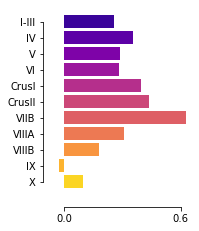

In [8]:
# plot
_, ax = plt.subplots(figsize=[2.5,3.5])
ax.barh(h2_anat_df.loc[::-1, 'lobule'], h2_anat_df.loc[::-1, 'h2'], color=palette_cb[::-1])

ax.set_ylabel(None)
# axes[i].tick_params(colors='gray', which='both')
ax.set_xticks((0, 0.6))
sns.despine(offset=10, trim=True)